In [1]:
!date

Mon Mar 28 15:41:53 EDT 2022


In [2]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt

from tqdm import tqdm

In [4]:
def load_dir(abide_dir):
    abide_dir = os.path.expanduser(abide_dir)
    files = os.listdir(abide_dir)
    files.sort()
    files = np.array(files)
    cmats = np.array([np.load(os.path.join(abide_dir,file)) for file in tqdm(files)])
    return cmats,files

In [5]:
cmats1,files1 = load_dir('~/BC-fMRI-AE/Assets/ABIDE-I-cmats-frc/')
cmats1.shape

100%|██████████| 1068/1068 [00:01<00:00, 736.15it/s]


(1068, 51, 51)

In [6]:
cmats2,files2 = load_dir('~/BC-fMRI-AE/Assets/ABIDE-II-cmats-frc/')
cmats2.shape

100%|██████████| 960/960 [00:01<00:00, 736.39it/s]


(960, 51, 51)

In [7]:
rel_cmat1,rel_files1 = load_dir('~/BC-fMRI-AE/Assets/ABIDE-I-rel-cmats-frc/')
rel_cmat1.shape

100%|██████████| 1063/1063 [00:01<00:00, 696.21it/s]


(1063, 2, 51, 51)

In [8]:
rel_cmat2,rel_files2 = load_dir('~/BC-fMRI-AE/Assets/ABIDE-II-rel-cmats-frc/')
rel_cmat2.shape

100%|██████████| 960/960 [00:01<00:00, 668.03it/s]


(960, 2, 51, 51)

In [9]:
scan_lenghts1 = pd.read_csv('../Data/Scan_lenghts_ABIDEI.csv')
scan_lenghts2 = pd.read_csv('../Data/Scan_lenghts_ABIDEII.csv')

print(scan_lenghts1.shape)
print(scan_lenghts2.shape)

scan_lenghts1 = scan_lenghts1.iloc[scan_lenghts1['sub'].isin([val[0:11] for val in rel_files1]).values]
scan_lenghts2 = scan_lenghts2.iloc[scan_lenghts2['sub'].isin([val[0:9] for val in rel_files2]).values]

print(scan_lenghts1.shape)
print(scan_lenghts2.shape)

(1068, 3)
(966, 3)
(1063, 3)
(960, 3)


In [10]:
#scan_lenghts1 = scan_lenghts1.iloc[keep_idx1]

In [11]:
good_subs1 = scan_lenghts1['sub'].values[scan_lenghts1['scan_length'].values > 4]
good_subs2 = scan_lenghts2['sub'].values[scan_lenghts2['scan_length'].values > 4]
(len(good_subs1),len(good_subs2))

(894, 704)

In [12]:
def is_in(v1,v2):
    return np.array([val in v2 for val in v1])

In [13]:
def trim_mat(mat,subs,good_subs):
    'trims cmat according to good subs'
    subs = np.array(subs)
    slice_ = is_in(subs,good_subs)
    
    if mat.ndim==3:
        mat_trimmed = mat[slice_,:,:]
    elif mat.ndim==4:
        mat_trimmed = mat[slice_,:,:,:]
        
    subs_trimmed  = subs[slice_]
    
    assert subs_trimmed.shape[0]==good_subs.shape[0],'bad len'
    assert all([subs_trimmed[i]==good_subs[i] for i in range(len(good_subs))]), 'bad order'
    
    return mat_trimmed,subs_trimmed

In [14]:
# TRIM ABIDE I
cmats1_trimmed,files1_trimmed = trim_mat(cmats1,[val[4:15] for val in files1],good_subs1)
rel_cmat1_trimmed,rel_files1_trimmed = trim_mat(rel_cmat1,[val[0:11] for val in rel_files1],good_subs1)

In [15]:
print(cmats1_trimmed.shape)
print(files1_trimmed.shape)
print(rel_cmat1_trimmed.shape)
print(rel_files1_trimmed.shape)

(894, 51, 51)
(894,)
(894, 2, 51, 51)
(894,)


In [16]:
# TRIM ABIDE II
cmats2_trimmed,files2_trimmed = trim_mat(cmats2,[val[0:9] for val in files2],good_subs2)
rel_cmat2_trimmed,rel_files2_trimmed = trim_mat(rel_cmat2,[val[0:9] for val in rel_files2],good_subs2)

In [17]:
print(cmats2_trimmed.shape)
print(files2_trimmed.shape)
print(rel_cmat2_trimmed.shape)
print(rel_files2_trimmed.shape)

(704, 51, 51)
(704,)
(704, 2, 51, 51)
(704,)


In [18]:
cmats1,files1 = cmats1_trimmed,files1_trimmed
rel_cmat1,rel_files1 = rel_cmat1_trimmed,rel_files1_trimmed
cmats2,files2 = cmats2_trimmed,files2_trimmed
rel_cmat2,rel_files2 = rel_cmat2_trimmed,rel_files2_trimmed

In [19]:
scan_lenghts2 = scan_lenghts2.iloc[is_in(scan_lenghts2['sub'].values,good_subs2)]
scan_lenghts1 = scan_lenghts1.iloc[is_in(scan_lenghts1['sub'].values,good_subs1)]

In [20]:
def flatten_cmat(cmats):
    ns = cmats.shape[0]
    ni = cmats.shape[-1]
    tridx = np.triu_indices(n=ni,k=1)
    mat_flat = np.array([cmats[i,:,:][tridx] for i in range(ns)])
    return mat_flat

In [21]:
flat_cmats1 = flatten_cmat(cmats1)
flat_cmats2 = flatten_cmat(cmats2)

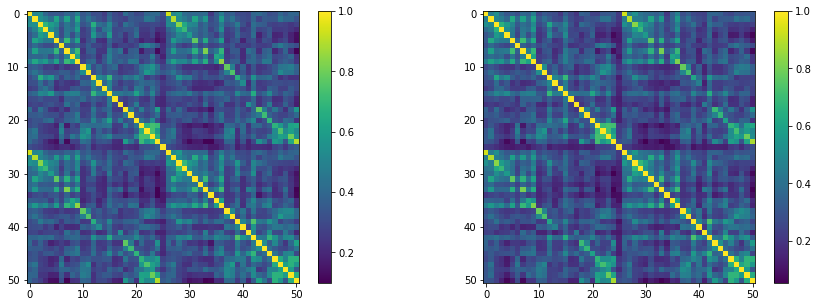

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(cmats1.mean(axis=0))
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(cmats2.mean(axis=0))
plt.colorbar()

In [23]:
np.corrcoef(flat_cmats1.mean(axis=0),flat_cmats2.mean(axis=0))[0,1]

0.9864923555136403

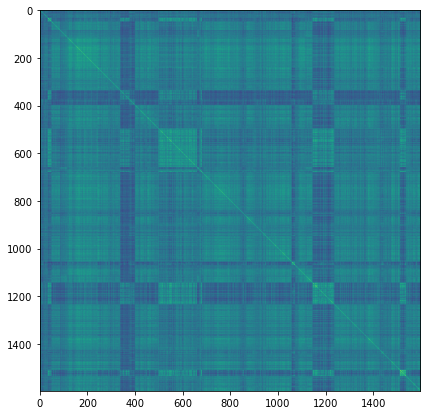

In [24]:
cross_c = np.corrcoef(np.vstack((flat_cmats1,flat_cmats2)))
plt.figure(figsize=(7,7))
plt.imshow(cross_c)

In [25]:
s1 = cmats1.shape[0]
s2 = cmats2.shape[0]
(s1,s2)

(894, 704)

In [26]:
c1 = cross_c[0:s1,:][:,0:s1]
c2 = cross_c[s1:s1+s2,:][:,s1:s1+s2]
c3 = cross_c[0:s1,:][:,s1:s1+s2]

In [27]:
def get_triu(c1):
    return c1[np.triu_indices(n=c1.shape[0],k=1)]

/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

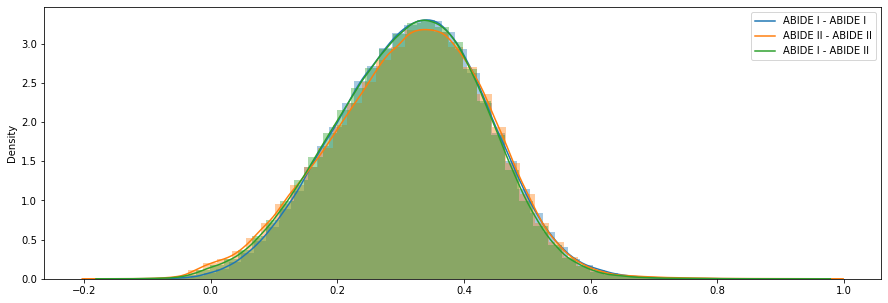

In [28]:
plt.figure(figsize=(15,5))
sns.distplot(get_triu(c1))
sns.distplot(get_triu(c2))
sns.distplot(c3.flatten())
plt.legend(['ABIDE I - ABIDE I','ABIDE II - ABIDE II','ABIDE I - ABIDE II'])

In [29]:
print(f'ABIDE I within: M={get_triu(c1).mean():.2f}, SD={get_triu(c1).std():.2f} {get_triu(c1).min():.2f}-{get_triu(c1).max():.2f}')
print(f'ABIDE II within: M={get_triu(c2).mean():.2f}, SD={get_triu(c2).std():.2f} {get_triu(c2).min():.2f}-{get_triu(c2).max():.2f}')
print(f'Across: M={c3.flatten().mean():.2f}, SD={c3.flatten().std():.2f} {c3.flatten().min():.2f}-{c3.flatten().max():.2f}')

ABIDE I within: M=0.32, SD=0.12 -0.11-0.88
ABIDE II within: M=0.31, SD=0.12 -0.17-0.97
Across: M=0.31, SD=0.12 -0.16-0.95


### First-Second Half Correlation

In [30]:
rel_cmat1_1 = flatten_cmat(rel_cmat1[:,0,:,:])
rel_cmat1_2 = flatten_cmat(rel_cmat1[:,1,:,:])

rel_cmat2_1 = flatten_cmat(rel_cmat2[:,0,:,:])
rel_cmat2_2 = flatten_cmat(rel_cmat2[:,1,:,:])

In [31]:
rel_vals1 = np.array([np.corrcoef(rel_cmat1_1[n,:],rel_cmat1_2[n,:])[0,1] for n in range(rel_cmat1.shape[0])])
rel_vals2 = np.array([np.corrcoef(rel_cmat2_1[n,:],rel_cmat2_2[n,:])[0,1] for n in range(rel_cmat2.shape[0])])

In [32]:
(rel_vals1.mean().round(2),rel_vals2.mean().round(2))

(0.54, 0.55)

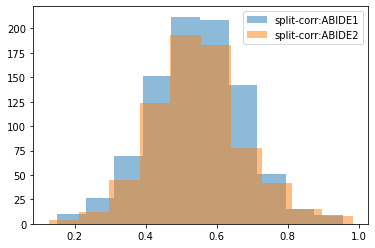

In [33]:
plt.hist(rel_vals1,alpha=.5)
plt.hist(rel_vals2,alpha=.5)
plt.legend(['split-corr:ABIDE1','split-corr:ABIDE2'])

In [34]:
def get_ranks(rel_cmat1_1,rel_cmat1_2,measure='pearson'):
    
    if measure=='pearson':
        big = np.corrcoef(np.vstack((rel_cmat1_1,rel_cmat1_2)))
        n = int(big.shape[0]/2)
        fs = big[n::,:][:,0:n]
        
    elif measure=='kendall':
        from scipy.stats import kendalltau
        r = kendalltau
        n = rel_cmat1_1.shape[0]
        fs = np.zeros((n,n))
        for i in tqdm(range(n)):
            for j in range(n):
                fs[i,j] = r(rel_cmat1_1[i,:],rel_cmat1_2[j,:])[0]
        
    ranks = np.array([[np.nonzero(np.argsort(fs[s,:])[-1::-1]==s)[0][0]+1] for s in range(n)])[:,0]
    return ranks

In [35]:
ranks1 = get_ranks(rel_cmat1_1,rel_cmat1_2)
ranks2 = get_ranks(rel_cmat2_1,rel_cmat2_2)

In [37]:
#ranks1 = get_ranks(rel_cmat1_1,rel_cmat1_2,measure='kendall')
#ranks2 = get_ranks(rel_cmat2_1,rel_cmat2_2,measure='kendall')

In [38]:
print('Rank acc')
((ranks1==1).mean().round(2),(ranks2==1).mean().round(2))

Rank acc


(0.59, 0.6)

In [39]:
# Correlation of FC rel and scan_duration 
print(np.corrcoef(rel_vals1,scan_lenghts1['scan_length'].values)[0,1].round(2))
print(np.corrcoef(rel_vals2,scan_lenghts2['scan_length'].values)[0,1].round(2))

0.22
0.05


In [40]:
df1 = pd.read_csv('../Data/ABIDE_df3.csv')
df1 = df1.iloc[is_in(df1['participant_id'].values,[int(val[6::]) for val in good_subs1])]

df2 = pd.read_csv('../Data/ABIDE2_df.csv')
df2 = df2.iloc[is_in(df2['participant_id'].values,[int(val[4::]) for val in good_subs2])]
df2 = df2.sort_values(by='participant_id')

In [41]:
good_subs = df2['participant_id'].astype(str).values
cmats2_trim, files2_trim = trim_mat(cmats2,[val[4::] for val in files2],good_subs)
rel_cmat2_trim, rel_files2_trim = trim_mat(rel_cmat2,[val[4::] for val in rel_files2],good_subs)
assert all([files2_trim[i]==good_subs[i] for i in range(len(good_subs))])
print(cmats2_trim.shape)
print(rel_cmat2_trim.shape)

(655, 51, 51)
(655, 2, 51, 51)


In [45]:
good_subs = df1['participant_id'].astype(str).values
cmats1_trim, files1_trim = trim_mat(cmats1,[val[6::] for val in files1],good_subs)
rel_cmat1_trim, rel_files1_trim = trim_mat(rel_cmat1,[val[6::] for val in rel_files1],good_subs)
assert all([files1_trim[i]==good_subs[i] for i in range(len(good_subs))])
print(cmats1_trim.shape)
print(rel_cmat1_trim.shape)

(847, 51, 51)
(847, 2, 51, 51)


In [46]:
ab1_df = pd.DataFrame()
ab1_df['participant_id'] = df1['participant_id'].astype(str)
ab1_df['diag'] = df1['DX_GROUP']
ab1_df['age'] = df1['AGE_AT_SCAN']
ab1_df['sex'] = df1['SEX']
ab1_df['fiq'] = df1['FIQ']
ab1_df['site'] = df1['site'].astype(str)
ab1_df['DSMIV'] = df1['DSM_IV_TR']
ab1_df['ados_total'] = df1['ADOS_TOTAL']
ab1_df['ados_social'] = df1['ADOS_SOCIAL']
ab1_df['ados_comm'] = df1['ADOS_COMM']
ab1_df['ados_rrb'] = df1['ADOS_STEREO_BEHAV']
ab1_df['dataset'] = np.array(['ABIDE I' for i in range(len(df1))])
ab1_df.shape

(847, 12)

In [47]:
ab2_df = pd.DataFrame()
ab2_df['participant_id'] = df2['participant_id'].astype(str)
ab2_df['diag'] = df2['dx_group']
ab2_df['age'] = df2['age_at_scan ']
ab2_df['sex'] = df2['sex']
ab2_df['fiq'] = df2['fiq']
ab2_df['site'] = df2['site_id'].astype(str)
ab2_df['DSMIV'] = df2['pdd_dsm_iv_tr']
ab2_df['ados_total'] = df2['ados_g_total']
ab2_df['ados_social'] = df2['ados_g_social']
ab2_df['ados_comm'] = df2['ados_g_comm']
ab2_df['ados_rrb'] = df2['ados_g_stereo_behav']
ab2_df['dataset'] = ['ABIDE II' for i in range(len(df2))]
ab2_df.shape

(655, 12)

In [48]:
comb_df = ab1_df.append(ab2_df)
comb_df

,participant_id,diag,age,sex,fiq,site,DSMIV,ados_total,ados_social,ados_comm,ados_rrb,dataset
0,50002,1,16.77,1,103.0,13,1.0,12.0,8.0,4.0,3.0,ABIDE I
2,50004,1,19.09,1,113.0,13,1.0,18.0,12.0,6.0,2.0,ABIDE I
3,50005,1,13.73,2,119.0,13,1.0,12.0,8.0,4.0,1.0,ABIDE I
4,50006,1,13.37,1,109.0,13,1.0,12.0,8.0,4.0,4.0,ABIDE I
9,50011,1,16.93,1,111.0,13,1.0,13.0,9.0,4.0,NaN,ABIDE I
...,...,...,...,...,...,...,...,...,...,...,...,...
746,30163,2,8.00,2,136.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II
747,30164,2,10.00,2,115.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II
748,30165,2,12.00,2,120.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II
749,30166,2,10.00,2,112.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II


In [49]:
comb_df.to_csv('../Data/comb_df.csv')

In [50]:
cmats1_trimmed.shape

(894, 51, 51)

In [51]:
cmats2_trimmed.shape

(704, 51, 51)

In [52]:
arr = np.concatenate((cmats1_trim,cmats2_trim),axis=0)
np.savez_compressed('../Data/cmats_r51_S1502.npz',data=(arr+1)/2)

In [53]:
arr = np.concatenate((rel_cmat1_trim,rel_cmat2_trim),axis=0)
np.savez_compressed('../Data/rel-cmats_r51_S1502.npz',data=(arr+1)/2)

In [54]:
!date

Mon Mar 28 15:46:39 EDT 2022
